In [1]:
%matplotlib inline

### New USPORF classes (adapted from eif.py)
[eif.py link](https://github.com/sahandha/eif/blob/master/eif_old.py)

### Example

- Note: need to download: _urerfNew.py_ 
- command: `import urerfNew`

In [2]:
"""
update: adjust EIF to have the same function as IsoForest

isoForest2: change the import to be global
eif2: add fit(self,X) -> problem: the heatmap of 1st data
eif3: add fit, decision_function, predict, change the variable name,
    : correct follow `flake8`
    -> problem the heat map of 1st data, +runtime
eif4: add fit(), change other classes to function
"""

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from rerf.urerf import UnsupervisedRandomForest
# from sklearn.ensemble import IsolationForest
from urerf2 import UnsupervisedRandomForest_new  # adjusted class
import eif as iso

from iforest2 import IsolationForest2
import eif2 as iso2 
import urerfNew

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import tree
from sklearn import datasets
import matplotlib.cm as cm
from scipy import interpolate

# print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# -------------------------------------------------
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_inliers, 2) - 0.5)
]

# label the ground truth
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)

# -------------------------------------------------
# algorithm
anomaly_algorithms = [
#     ("IF", IsolationForest(contamination=outliers_fraction,
#                            n_estimators=100, random_state=0)),
#     ("IF_new", IsolationForest2(contamination=outliers_fraction,
#                            n_estimators=100, random_state=0)),
#     ("EIF0",0),
    ("EIF2", iso2.iForest(ntrees=100, sample_size=256, ExtensionLevel=0)),
#     ("EIF_new", iso3.iForest(contamination=outliers_fraction,
#                                n_estimators=100, random_state=0)),
    ("USPORF", UnsupervisedRandomForest_new(n_estimators=100, random_state=0)),
    ("USPORF_new", urerfNew.UForest(n_estimators=100)),
]

In [3]:
#-------------------------------------------------------------------
# related functions
def mat_to_score(mat, power =2):
    s = (mat**power).sum(axis=1)/mat.shape[0]
    return s

def decision_function(s_train, s_test, less_inlier = True): # array
    if s_test is None:
        s_test=s_train
    if less_inlier == True: 
        s_train = s_train
        s_test = s_test
    if less_inlier == False: 
        s_train = -s_train
        s_test = -s_test
    offset_ = np.percentile(s_train, outliers_fraction*100)
    decision_function = s_test - offset_
    return decision_function
    
def OutPredict(decision_function):
    is_inlier = np.ones(decision_function.shape[0], dtype=int)
    is_inlier[decision_function <= 0] = -1
    return is_inlier

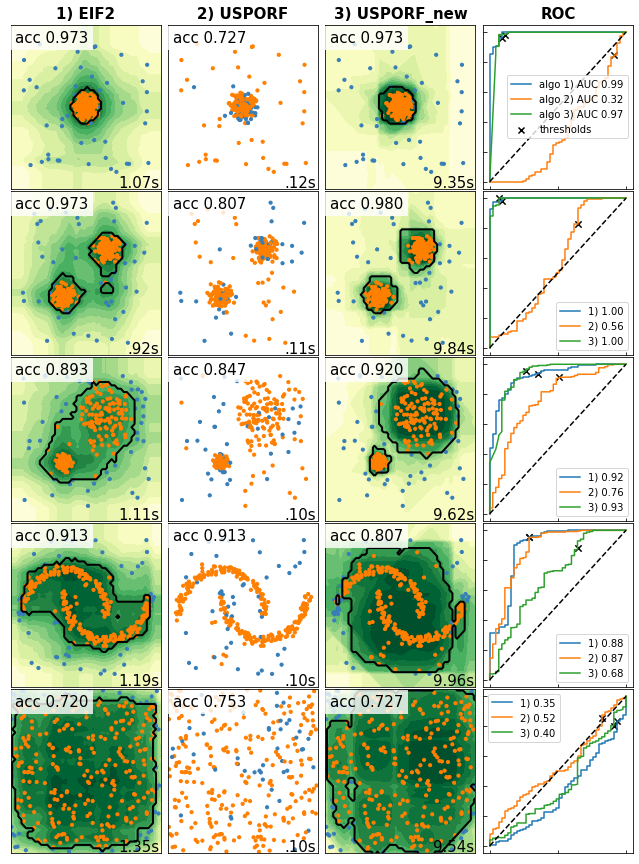

In [4]:
# -------------------------------------------------
# plot

# plot setting
grid_len = np.linspace(-7, 7, 50)
xx, yy = np.meshgrid(grid_len,grid_len)

plt.figure(figsize=((len(anomaly_algorithms)+1) * 2+1, len(datasets)*2.2+1))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(0)

# add outliers
for i_dataset, X in enumerate(datasets):
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)
    
    # list of AUC and ROC
    list_AUC = []
    list_fpr = []
    list_tpr = []
    list_thresh = []
    
    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        # fit
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        # predict outlier
        if name == "IF": # or name == "IF_new" or name =="EIF_new":
            probas_ = algorithm.fit(X).decision_function(X)
            y_pred = algorithm.predict(X)
        elif name == "EIF2" or name == "USPORF_new":
            s = algorithm.compute_paths(X)
            probas_ = decision_function(s_train=s, s_test=s, less_inlier= False)
            y_pred = OutPredict(decision_function=probas_)
        else:
            d_sim = algorithm.transform()
            s = mat_to_score(mat=d_sim)
            probas_ = decision_function(s_train=s, s_test=s, less_inlier= True)
            y_pred = OutPredict(decision_function=probas_)
        
        AUC = roc_auc_score(y_true, probas_)
        fpr, tpr, thresholds = roc_curve(y_true, probas_)
        thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]
        # store ROC curve
        list_AUC.append(AUC)
        list_fpr.append(fpr)
        list_tpr.append(tpr)
        list_thresh.append(thresh_index)

        acc = accuracy_score(y_true, y_pred) # acuracy
        t1 = time.time()
        
        plt.subplot(len(datasets), len(anomaly_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(str(algo_index + 1) + ") " + name, size=15, weight="bold")
        
#------------------------------------------------------ 
# plot contour and decision boundary

        if name == "IF":
            probas_map = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
                
            probas_map= probas_map.reshape(xx.shape)
            Z = Z.reshape(xx.shape)
            lvls = np.linspace(np.min(probas_map),np.max(probas_map),15)
            plt.contourf(xx, yy, probas_map, lvls, cmap=plt.cm.YlGn)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')                

        elif name == "EIF2" or name == "USPORF_new":
            s_test = algorithm.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
            probas_map = decision_function(s_train=s, s_test=s_test,less_inlier= False)
            Z = OutPredict(probas_map)
            
            probas_map= probas_map.reshape(xx.shape)
            Z = Z.reshape(xx.shape)
            lvls = np.linspace(np.min(probas_map),np.max(probas_map),15)
            plt.contourf(xx, yy, probas_map, lvls, cmap=plt.cm.YlGn)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black') 

#-----------------------------------------------------------
# plot outlier prediction
        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        
        # show prediction accuracy
        bbox_props = dict(boxstyle="square", fc="white", ec="none", alpha =0.8)
        plt.text(.03, .89, ("acc %.3f" % acc).lstrip("0"),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment="left", bbox = bbox_props)        
        plot_num += 1
        algo_index += 1
        
#------------------------------------------------------    
# plot the ROC curves and show AUC scores

    plt.subplot(len(datasets), len(anomaly_algorithms) + 1, plot_num) # +1 for ROC column

    if i_dataset == 0:
        plt.title("ROC", size=15, color="black", weight="bold")
        
        # lebel the decision_function's thresholds
        plt.scatter([], [], marker="x", color="black", label="thresholds")
        
    for algo_index in range(len(anomaly_algorithms)):
        
        if i_dataset == 0:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label="algo " + str(algo_index + 1)+ ")"
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"))
        else:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label= str(algo_index + 1)+ ")"
                + (" %.2f" % list_AUC[algo_index]).lstrip("0"))
        
        plt.scatter(
        list_fpr[algo_index][list_thresh[algo_index]],
        list_tpr[algo_index][list_thresh[algo_index]],
        s=40, marker="x", color = 'black')
            
    plt.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    plt.legend()
    plt.tick_params(labelleft = False, labelbottom = False, direction  = "in")
    plot_num += 1     
            
plt.show()